<a href="https://colab.research.google.com/github/ozhao1323/ECON3916-Statistical-and-Machine-Learning/blob/main/Assignment%202/Econ_3916_Assignment_2_Audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [4]:
# Manual DGP Simulation
import numpy as np
normal_traffic = np.random.randint(20, 50, 980)
spike_traffic = np.random.randint(1000, 5000, 20)
latency_logs = np.concatenate([normal_traffic, spike_traffic])

In [5]:
def calculate_mad(data):
    median = np.median(data)
    absolute_deviations = np.abs(data - median)
    return np.median(absolute_deviations)

sd = np.std(latency_logs)
mad = calculate_mad(latency_logs)

print(f"Standard Deviation: {sd:.2f} ms")
print(f"MAD:                {mad:.2f} ms")

Standard Deviation: 388.05 ms
MAD:                7.50 ms


In [7]:
def bayesian_audit(prior, sensitivity, specificity):
    """
    Calculates P(Cheater | Flagged) using Bayes' Theorem.

    P(Flagged | Cheater)     = sensitivity
    P(Flagged | Not Cheater) = 1 - specificity  (false positive rate)

    Bayes: P(Cheater | Flagged) = [P(Flagged|Cheater) * P(Cheater)] /
                                   P(Flagged)
    where P(Flagged) = P(F|Cheat)*P(Cheat) + P(F|Clean)*P(Clean)
    """
    p_cheater        = prior
    p_clean          = 1 - prior
    p_flag_cheater   = sensitivity
    p_flag_clean     = 1 - specificity          # false positive rate

    # Total probability of being flagged (denominator)
    p_flagged = (p_flag_cheater * p_cheater) + (p_flag_clean * p_clean)

    # Posterior: P(Cheater | Flagged)
    posterior = (p_flag_cheater * p_cheater) / p_flagged
    return posterior

scenarios = {
    "A — Bootcamp    (Base Rate = 50.0%)": 0.50,
    "B — Econ Class  (Base Rate =  5.0%)": 0.05,
    "C — Honors Sem  (Base Rate =  0.1%)": 0.001,
}

print("=" * 55)
print("PHASE 2 RESULTS: P(Actually Cheating | Flagged)")
print("=" * 55)
for label, prior in scenarios.items():
    posterior = bayesian_audit(prior, sensitivity=0.98, specificity=0.98)
    print(f"{label}  →  {posterior*100:.2f}%")
print()

PHASE 2 RESULTS: P(Actually Cheating | Flagged)
A — Bootcamp    (Base Rate = 50.0%)  →  98.00%
B — Econ Class  (Base Rate =  5.0%)  →  72.06%
C — Honors Sem  (Base Rate =  0.1%)  →  4.68%



In [9]:
# PHASE 3: BIAS AUDIT — Chi-Square SRM Test

observed = np.array([50_250, 49_750])
expected = np.array([50_000, 50_000])

# Manual Chi-Square: Σ (O - E)² / E
chi_square_stat = 0
for o, e in zip(observed, expected):
    chi_square_stat += (o - e)**2 / e

critical_value = 3.84   # p < 0.05, df = 1

print(f"Observed:          Control={observed[0]:,}  |  Treatment={observed[1]:,}")
print(f"Expected (each):   {expected[0]:,}")
print(f"Chi-Square Stat:   {chi_square_stat:.4f}")
print(f"Critical Value:    {critical_value} (p < 0.05, df=1)")
print()
if chi_square_stat > critical_value:
    print("VERDICT: EXPERIMENT INVALID — SRM Detected.")
    print("The 500-user imbalance is statistically significant.")
    print("Engineering bias likely caused Treatment dropout.")
else:
    print("VERDICT: No significant SRM detected.")

Observed:          Control=50,250  |  Treatment=49,750
Expected (each):   50,000
Chi-Square Stat:   2.5000
Critical Value:    3.84 (p < 0.05, df=1)

VERDICT: No significant SRM detected.


     SURVIVORSHIP BIAS AUDIT — CRYPTO TOKEN LAUNCHES
  Total tokens simulated  :     10,000
  Survivor threshold (P99): $    14,503,997
  Survivors (top 1%)      :        100

  Mean Market Cap — ALL tokens      : $    10,523,924
  Mean Market Cap — SURVIVORS only  : $ 1,009,067,890

  ⚠  Survivorship Bias Multiplier   :       95.9×
     (Survivors look this many times 'better' than reality)


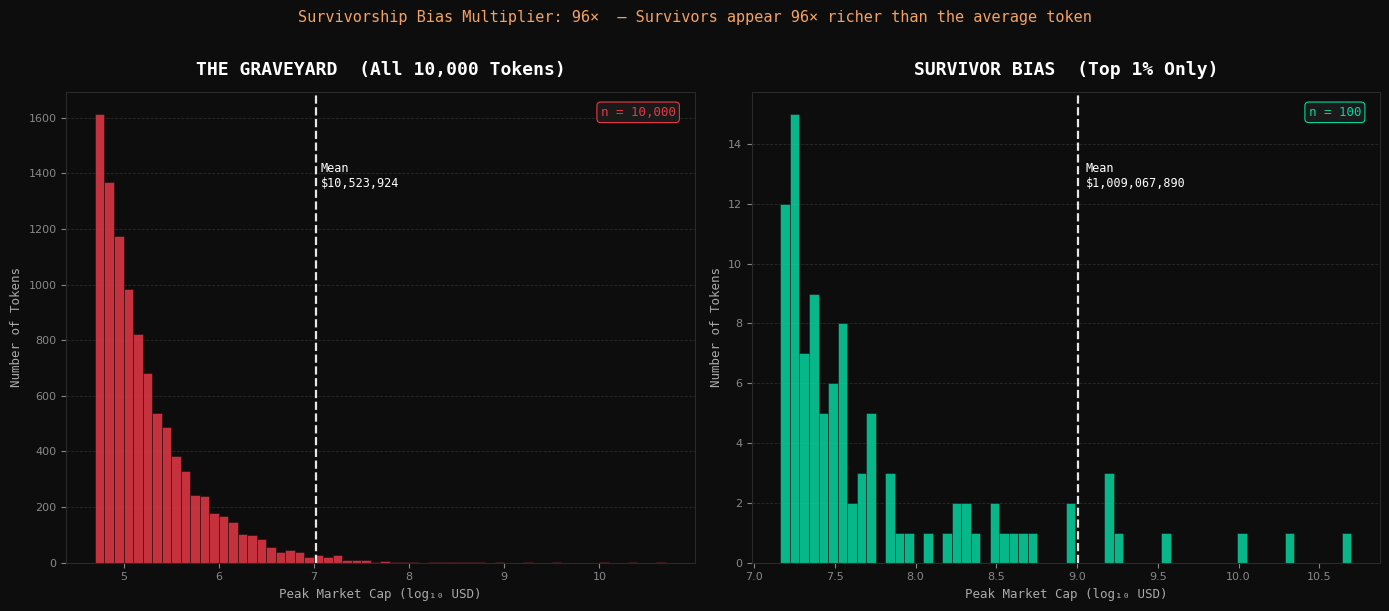


Chart saved → survivorship_bias.png


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# ── Reproducibility ──────────────────────────────────────────
np.random.seed(42)

# ============================================================
# 1. SIMULATE 10,000 TOKEN LAUNCHES  (Pareto / Power Law)
# ============================================================
N = 10_000
PARETO_SHAPE = 0.8          # shape < 1 → extremely heavy right tail
SCALE        = 50_000       # floor scale in USD

# Pareto draws: (scale / U^(1/shape)) gives power-law market caps
uniform_draws   = np.random.uniform(0, 1, N)
peak_market_cap = SCALE / (uniform_draws ** (1 / PARETO_SHAPE))

# Cap at a realistic ceiling (e.g. $50B)
peak_market_cap = np.clip(peak_market_cap, SCALE, 50_000_000_000)

# ── Build master DataFrame ────────────────────────────────────
df_all = pd.DataFrame({
    "token_id":       range(N),
    "peak_market_cap": peak_market_cap
})

# ── Survivorship: Top 1% by peak market cap ───────────────────
threshold    = np.percentile(peak_market_cap, 99)
df_survivors = df_all[df_all["peak_market_cap"] >= threshold].copy()

# ============================================================
# 2. PRINT THE BIAS METRICS
# ============================================================
mean_all       = df_all["peak_market_cap"].mean()
mean_survivors = df_survivors["peak_market_cap"].mean()
bias_multiple  = mean_survivors / mean_all

print("=" * 56)
print("     SURVIVORSHIP BIAS AUDIT — CRYPTO TOKEN LAUNCHES")
print("=" * 56)
print(f"  Total tokens simulated  : {N:>10,}")
print(f"  Survivor threshold (P99): ${threshold:>14,.0f}")
print(f"  Survivors (top 1%)      : {len(df_survivors):>10,}")
print()
print(f"  Mean Market Cap — ALL tokens      : ${mean_all:>14,.0f}")
print(f"  Mean Market Cap — SURVIVORS only  : ${mean_survivors:>14,.0f}")
print()
print(f"  ⚠  Survivorship Bias Multiplier   : {bias_multiple:>10.1f}×")
print("     (Survivors look this many times 'better' than reality)")
print("=" * 56)

# ============================================================
# 3. DUAL HISTOGRAM  —  styled for a VC forensics report
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor("#0d0d0d")
for ax in axes:
    ax.set_facecolor("#0d0d0d")

ACCENT_ALL  = "#e63946"
ACCENT_SURV = "#06d6a0"
GRID_COLOR  = "#2a2a2a"

# ── Log-scale values for readable bins ───────────────────────
log_all  = np.log10(df_all["peak_market_cap"] + 1)
log_surv = np.log10(df_survivors["peak_market_cap"] + 1)

def style_ax(ax, title, color, log_data, n_label, mean_val):
    ax.hist(log_data, bins=60, color=color, alpha=0.85,
            edgecolor="#0d0d0d", linewidth=0.4)

    ax.axvline(np.log10(mean_val), color="white", linewidth=1.6,
               linestyle="--", alpha=0.9)
    ax.text(np.log10(mean_val) + 0.05,
            ax.get_ylim()[1] * 0.85 if ax.get_ylim()[1] > 0 else 10,
            f"Mean\n${mean_val:,.0f}",
            color="white", fontsize=8.5, va="top",
            fontfamily="monospace")

    ax.set_title(title, color="white", fontsize=13,
                 fontweight="bold", pad=12, fontfamily="monospace")
    ax.set_xlabel("Peak Market Cap (log₁₀ USD)",
                  color="#aaaaaa", fontsize=9, fontfamily="monospace")
    ax.set_ylabel("Number of Tokens",
                  color="#aaaaaa", fontsize=9, fontfamily="monospace")
    ax.tick_params(colors="#888888", labelsize=8)
    for spine in ax.spines.values():
        spine.set_edgecolor(GRID_COLOR)
    ax.yaxis.grid(True, color=GRID_COLOR, linewidth=0.6, linestyle="--")
    ax.set_axisbelow(True)

    # Token count badge
    ax.text(0.97, 0.97, f"n = {n_label:,}", transform=ax.transAxes,
            color=color, fontsize=9, ha="right", va="top",
            fontfamily="monospace",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="#1a1a1a",
                      edgecolor=color, linewidth=0.8))

style_ax(axes[0], "THE GRAVEYARD  (All 10,000 Tokens)",
         ACCENT_ALL,  log_all,  N,             mean_all)
# Re-draw with correct ylim after first render
axes[0].figure.canvas.draw()

style_ax(axes[1], "SURVIVOR BIAS  (Top 1% Only)",
         ACCENT_SURV, log_surv, len(df_survivors), mean_survivors)

# ── Shared annotation banner ─────────────────────────────────
fig.suptitle(
    f"Survivorship Bias Multiplier: {bias_multiple:.0f}×  "
    f"— Survivors appear {bias_multiple:.0f}× richer than the average token",
    color="#f4a261", fontsize=11, fontfamily="monospace",
    y=1.01
)

plt.tight_layout()
plt.savefig("survivorship_bias.png", dpi=160,
            bbox_inches="tight", facecolor="#0d0d0d")
plt.show()
print("\nChart saved → survivorship_bias.png")
